In [11]:
import sys
sys.path.append('/mnt/antares_raid/home/oliver/nideep')
sys.path.append('/mnt/antares_raid/home/oliver/Scripts/autoencoder')
import numpy as np
import lmdb
import argparse
from collections import defaultdict
import matplotlib.pyplot as plt
import math
from nideep.eval.learning_curve import LearningCurve
from nideep.eval.inference import infer_to_h5_fixed_dims, infer_to_lmdb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nideep.eval.learning_curve import LearningCurve
from nideep.eval.eval_utils import Phase
%matplotlib inline

AER
AEUR
RAND
AENR25
AENUR25
AENR50
AENUR50
AER
AEUR
RAND
AENR25
AENUR25
AENR50
AENUR50


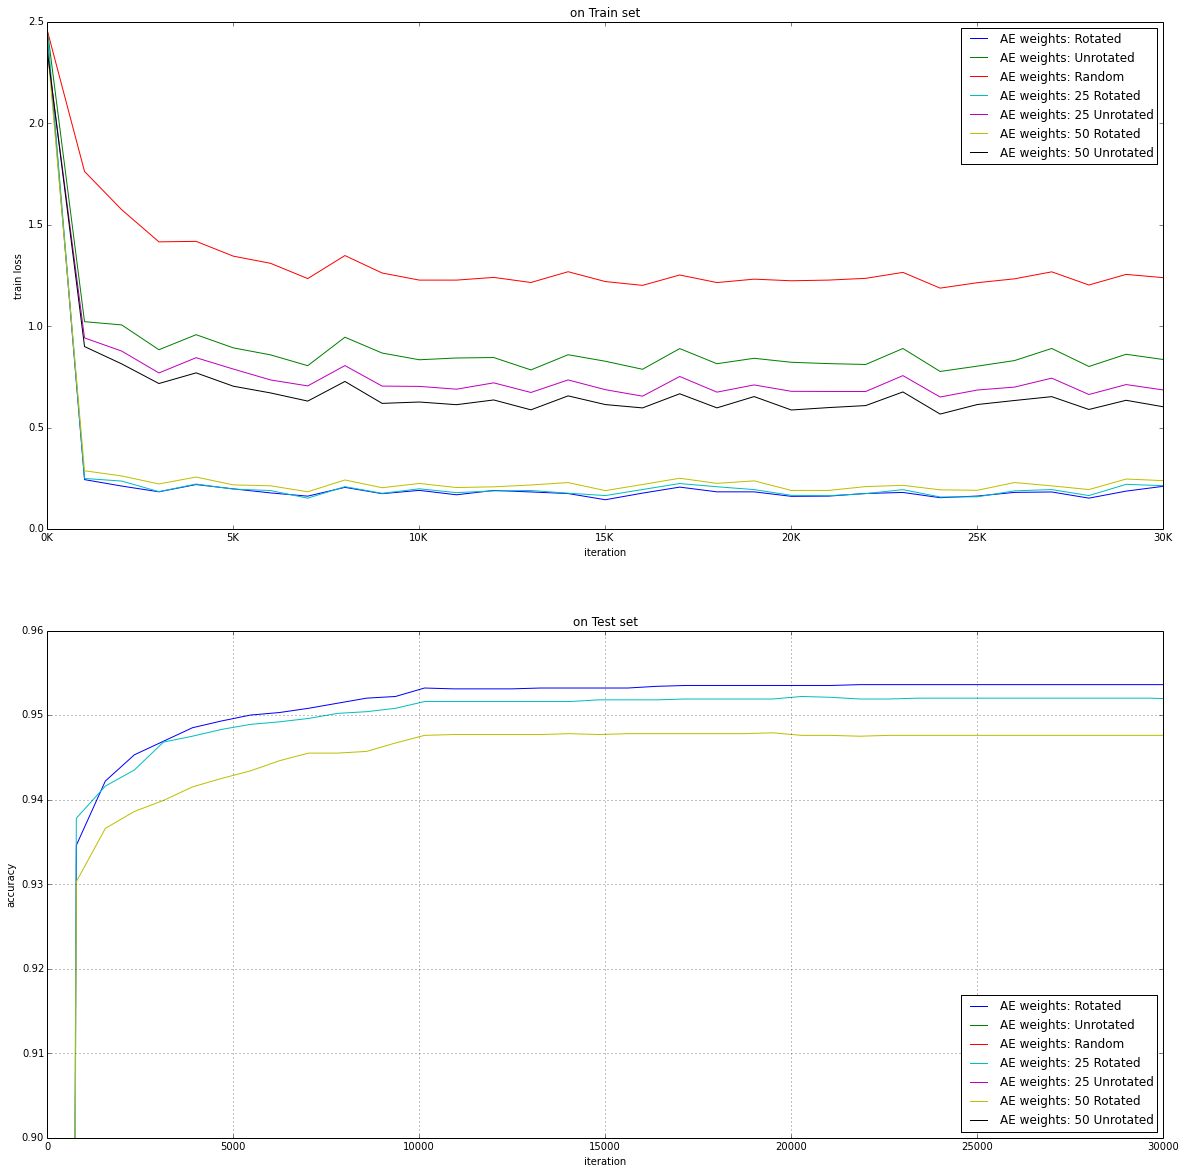

In [2]:
exps = ['AER', 'AEUR', 'RAND', 'AENR25', 'AENUR25', 'AENR50', 'AENUR50']

#exps = ['AER', 'AEUR', 'RAND', 'AENR25', 'AENUR25', 'AENR50']
#exps = ['RAND', 'AENR25', 'AENUR25']

exp_labels = ['Rotated', 'Unrotated', 'Random', '25 Rotated', '25 Unrotated', '50 Rotated' , '50 Unrotated']
date = '2408/'
exp_data = {'AER': {'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + 'MLP/AER/log/log.log'},
        'AEUR': {'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + 'MLP/AEUR/log/log.log'},
        'RAND':{'log': '/mnt/antares_raid/home/oliver/Experiments/' + date + 'MLP/RAND/log/log.log'},
        'AENR25':{'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + 'MLP/AE25NR/log/log.log'},
        'AENUR25': {'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + 'MLP/AE25NUR/log/log.log'},
        'AENR50':{'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + 'MLP/AE50NR/log/log.log'},
        'AENUR50':{'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + 'MLP/AE50NUR/log/log.log'},
        }
for exp in exps:
    print(exp)
    e = LearningCurve(exp_data[exp]['log'])
    e.parse()
    for phase in [Phase.TRAIN, Phase.TEST]:
        exp_data[exp][phase] = {}
        exp_data[exp][phase]['num_iter'] = e.list('NumIters', phase)
        exp_data[exp][phase]['loss'] = e.list('loss', phase)
        exp_data[exp][phase]['acc'] = e.list('accuracy', phase)

plt.figure(figsize=(20,20))
xmax = 30000
ymin = 0.9
ymax = 0.96
for i, exp in enumerate(exps):
    print(exp)
    plt.subplot(2,1,1)
    phase = Phase.TRAIN
    plt.plot(exp_data[exp][phase]['num_iter'], exp_data[exp][phase]['loss'], label='AE weights: %s' % (exp_labels[i],))
    plt.xlim(0,xmax)
    plt.xlabel('iteration')
    # format x-axis ticks
    ticks, _ = plt.xticks()
    plt.xticks(ticks, ["%dK" % int(t/1000) for t in ticks])
    plt.ylabel('train loss')
    plt.title("on %s set" % (phase,))
    plt.legend()
    
    phase = Phase.TEST
    plt.subplot(2,1,2)
    plt.plot(exp_data[exp][phase]['num_iter'],exp_data[exp][phase]['acc'], label='AE weights: %s' % (exp_labels[i],))
    plt.xlim(0,xmax)
    plt.ylim(ymin,ymax)
    plt.xlabel('iteration')
    plt.ylabel('accuracy')
    plt.title("on %s set" % (phase,))
    plt.legend(loc='lower right')
    plt.grid()

plt.show()


## Group comparison

In [12]:
dates_list = ['2408', '2708']
exps = ['AER', 'AEUR', 'RAND', 'AENR25', 'AENUR25', 'AENR50', 'AENUR50']

exp_data = dict()

for date in dates_list:
    
    exp_data.update({date:{'AER': {'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + '/MLP/AER/log/log.log'},
        'AEUR': {'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + '/MLP/AEUR/log/log.log'},
        'RAND':{'log': '/mnt/antares_raid/home/oliver/Experiments/' + date + '/MLP/RAND/log/log.log'},
        'AENR25':{'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + '/MLP/AE25NR/log/log.log'},
        'AENUR25': {'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + '/MLP/AE25NUR/log/log.log'},
        'AENR50':{'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + '/MLP/AE50NR/log/log.log'},
        'AENUR50':{'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + '/MLP/AE50NUR/log/log.log'},
            }
        })
    
    for exp in exps:
        e = LearningCurve(exp_data[date][exp]['log'])
        e.parse()
        for phase in [Phase.TRAIN, Phase.TEST]:
            exp_data[date][exp][phase] = {}
            exp_data[date][exp][phase]['num_iter'] = e.list('NumIters', phase)
            exp_data[date][exp][phase]['loss'] = e.list('loss', phase)
            exp_data[date][exp][phase]['acc'] = e.list('accuracy', phase)
            
        

In [13]:
#Extract Test accuracy and Trains loss over groups
acc = [[] for e in exps]
loss = [[] for e in exps]

for d,_ in exp_data.items():
    for i,e in enumerate(exps):
        acc[i].append(exp_data[d][e][Phase.TEST]['acc'])
        loss[i].append(exp_data[d][e][Phase.TRAIN]['loss'])
        
    
    
    


AER
AEUR
RAND
AENR25
AENUR25
AENR50
AENUR50


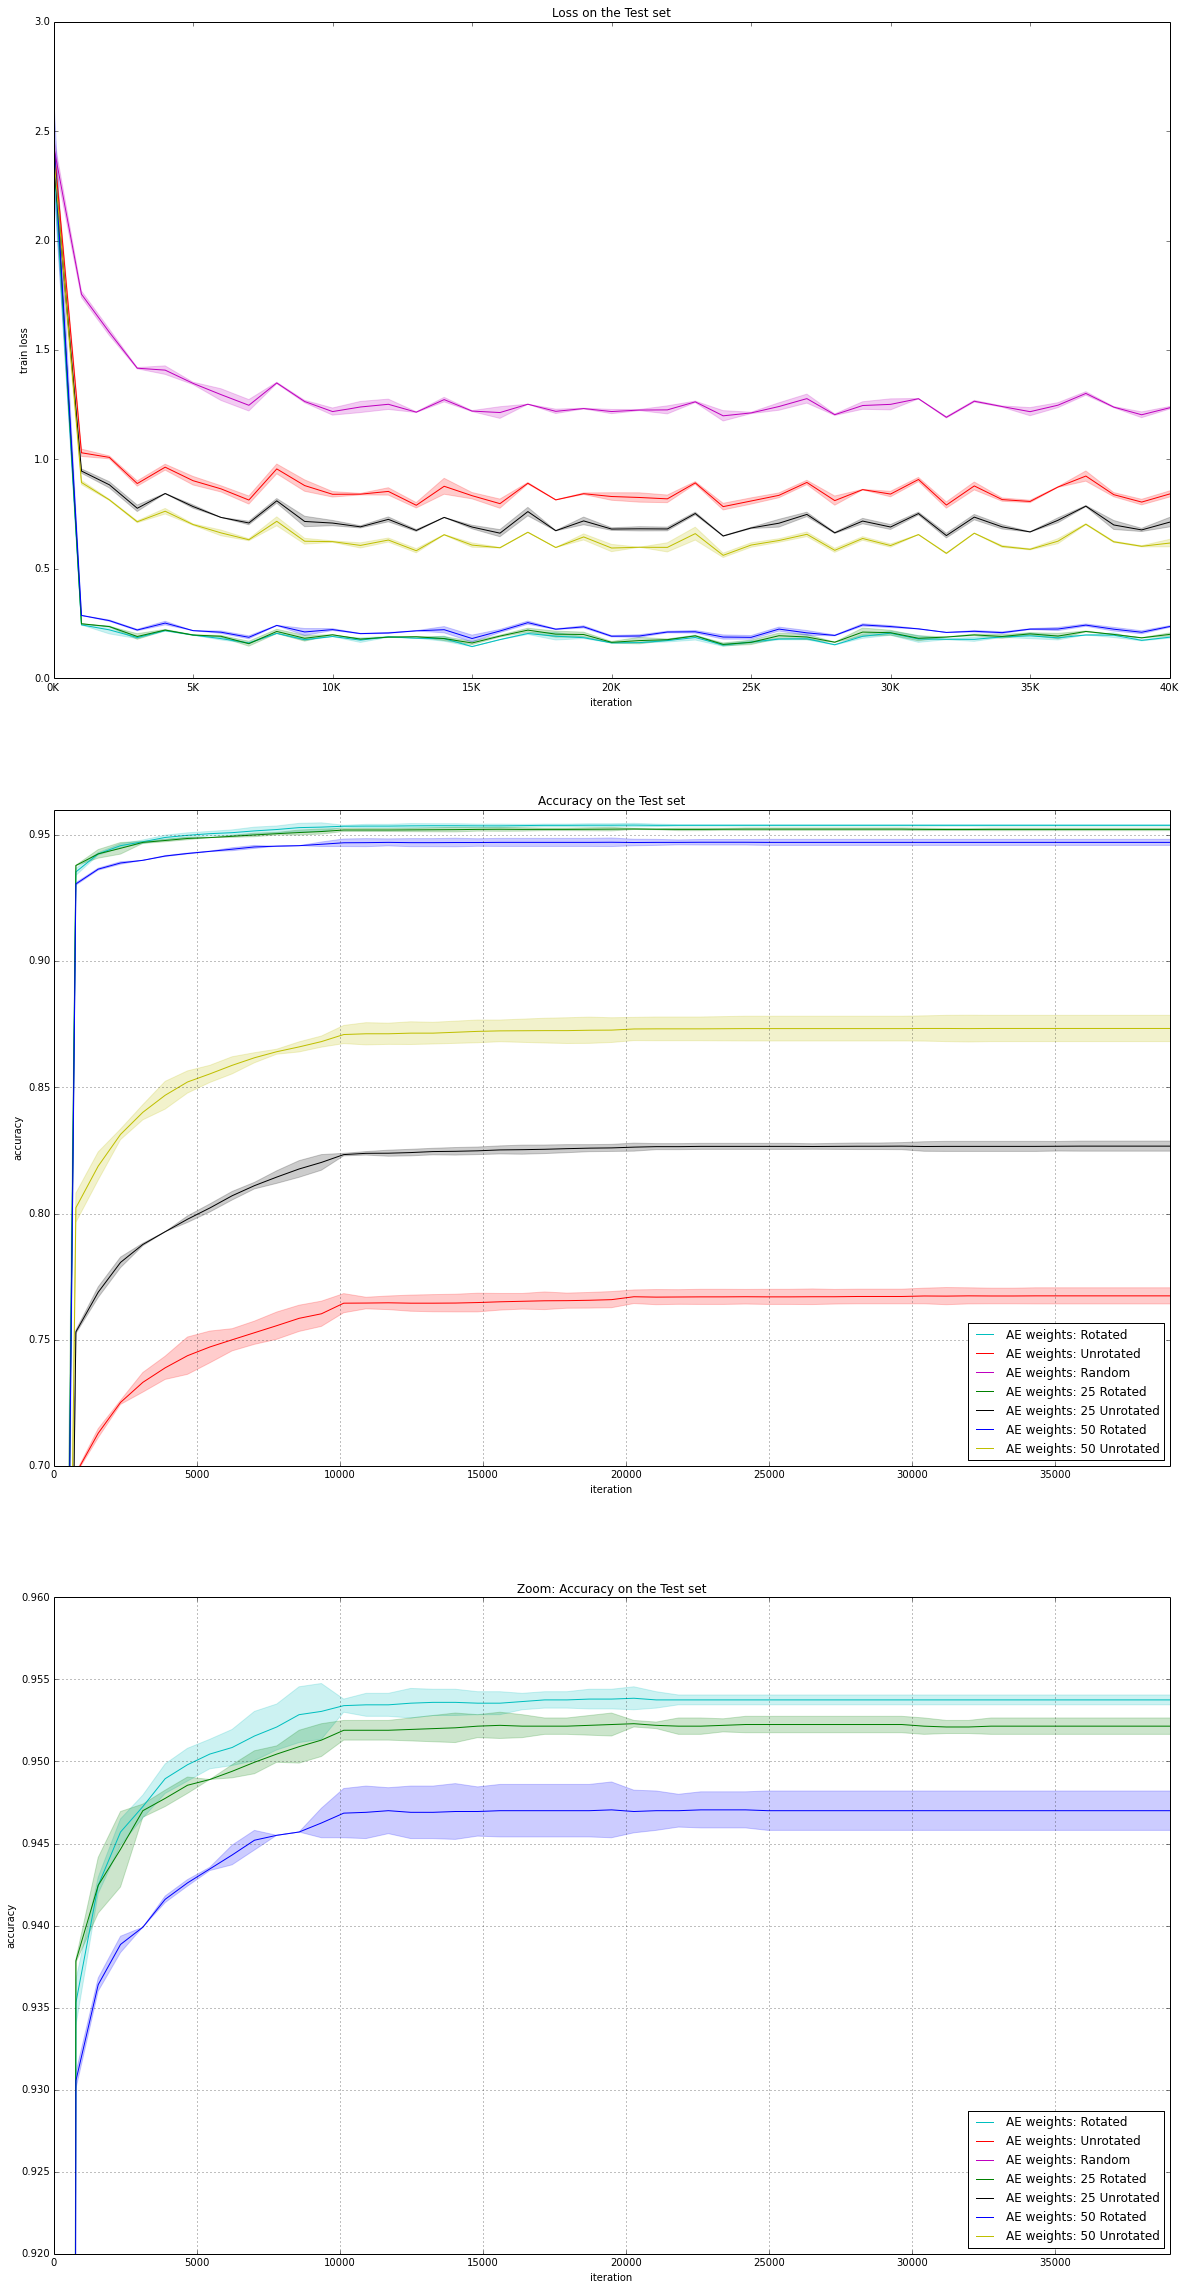

In [14]:
exp_labels = ['Rotated', 'Unrotated', 'Random', '25 Rotated', '25 Unrotated', '50 Rotated' , '50 Unrotated']
color = [ 'c','r', 'm','g', 'k','b', 'y']
fig = plt.figure(figsize=(20,40))
xmax = 39000
ymin = 0.7
ymax = 0.96
num_iter = exp_data['2408']['AER'][Phase.TEST]['num_iter']

for i,e in enumerate(exps):
    print(e)

    
    
    plt.subplot(3,1,1)
    ma = np.mean(loss[i], axis = 0).squeeze()
    mstd = np.std(loss[i], axis = 0).squeeze()
    num_iter = exp_data['2408']['AER'][Phase.TRAIN]['num_iter']
    plt.plot(num_iter, ma, label='AE weights: %s' % (exp_labels[i],), color=color[i])
    plt.fill_between(num_iter.squeeze(), ma-2*mstd, ma+2*mstd, color=color[i], alpha=0.2)
    plt.xlim(0,xmax)
    plt.xlabel('iteration')
    # format x-axis ticks
    ticks, _ = plt.xticks()
    plt.xticks(ticks, ["%dK" % int(t/1000) for t in ticks])
    plt.ylabel('train loss')
    plt.title("Loss on the %s set" % (phase,))
    
    
    ymin = 0.7
    ymax = 0.96
    plt.subplot(3,1,2)
    num_iter = exp_data['2408']['AER'][Phase.TEST]['num_iter']
    ma = np.mean(acc[i], axis = 0).squeeze()
    mstd = np.std(acc[i], axis = 0).squeeze()
    plt.plot(num_iter, ma, label='AE weights: %s' % (exp_labels[i],), color=color[i])
    plt.fill_between(num_iter.squeeze(), ma-2*mstd, ma+2*mstd, color=color[i], alpha=0.2)
    plt.xlim(0,xmax)
    plt.ylim(ymin,ymax)
    plt.xlabel('iteration')
    plt.ylabel('accuracy')
    plt.title("Accuracy on the %s set" % (phase,))
    plt.legend(loc='lower right')
    plt.grid()

    
    ymin = 0.92
    ymax = 0.96
    plt.subplot(3,1,3)
    num_iter = exp_data['2408']['AER'][Phase.TEST]['num_iter']
    ma = np.mean(acc[i], axis = 0).squeeze()
    mstd = np.std(acc[i], axis = 0).squeeze()
    plt.plot(num_iter, ma, label='AE weights: %s' % (exp_labels[i],), color=color[i])
    plt.fill_between(num_iter.squeeze(), ma-2*mstd, ma+2*mstd, color=color[i], alpha=0.2)
    plt.xlim(0,xmax)
    plt.ylim(ymin,ymax)
    plt.xlabel('iteration')
    plt.ylabel('accuracy')
    plt.title("Zoom: Accuracy on the %s set" % (phase,))
    plt.legend(loc='lower right')
    plt.grid()

plt.show()